### Comparison of optimizers for LASSO parameter range experiments

sklearn has 2 ways to fit logistic regression models with a LASSO penalty: [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (using the liblinear optimizer; i.e. coordinate descent), and [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) (which uses stochastic gradient descent). 

Here, we want to compare mutation prediction results between the two optimizers, for a single gene.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
ll_base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_lr_all_features'
)

# this doesn't have a sex covariate but it's probably close enough
sgd_base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_valid'
)

training_dataset = 'all_other_cancers'
ll_results_dir = os.path.join(ll_base_results_dir, training_dataset)
sgd_results_dir = os.path.join(sgd_base_results_dir, training_dataset)

plot_gene = 'EGFR'
metric = 'aupr'

### Get coefficient information for each lasso penalty

In [3]:
ll_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(ll_results_dir,
                                                              gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        ll_nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
ll_nz_coefs_df = pd.DataFrame(
    ll_nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
ll_nz_coefs_df.lasso_param = ll_nz_coefs_df.lasso_param.astype(float)
ll_nz_coefs_df.head()

,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,EGFR,ESCA,0.01,1,0,38
1,EGFR,ESCA,0.01,1,1,36
2,EGFR,ESCA,0.01,1,2,35
3,EGFR,ESCA,0.01,1,3,32
4,EGFR,ESCA,750.00,1,0,12923


In [4]:
sgd_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(sgd_results_dir,
                                                              gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        sgd_nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
sgd_nz_coefs_df = pd.DataFrame(
    sgd_nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
sgd_nz_coefs_df.lasso_param = sgd_nz_coefs_df.lasso_param.astype(float)
sgd_nz_coefs_df.head()

,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,EGFR,LGG,0.00025,42,0,7428
1,EGFR,LGG,0.00025,42,1,7507
2,EGFR,LGG,0.00025,42,2,7560
3,EGFR,LGG,0.00025,42,3,7517
4,EGFR,HNSC,0.00025,42,0,7391


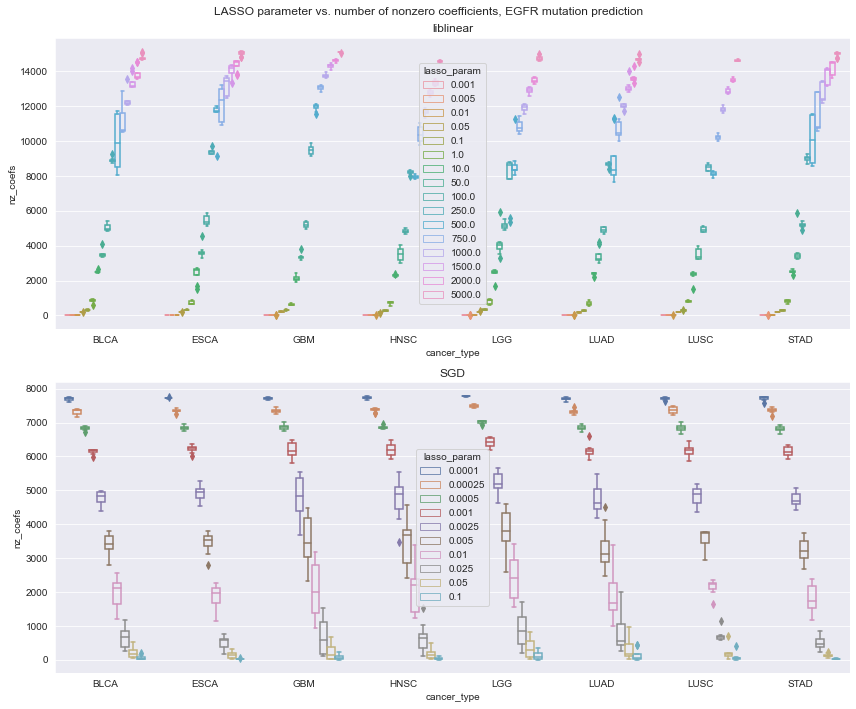

In [5]:
sns.set({'figure.figsize': (12, 10)})
fig, axarr = plt.subplots(2, 1)

def color_boxplot_edges(ax):
    # color the boxplot lines/edges rather than the box fill
    # this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
    # https://stackoverflow.com/a/72333641
    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # loop over them here, and use the same color as above
        for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers

    # also fix the legend to color the edges rather than fill
    for legpatch in ax.legend_.get_patches():
        col = legpatch.get_facecolor()
        legpatch.set_edgecolor(col)
        legpatch.set_facecolor('None')


sns.boxplot(
    data=ll_nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param', ax=axarr[0]
)
color_boxplot_edges(axarr[0])
axarr[0].set_title('liblinear')

sns.boxplot(
    data=sgd_nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param', ax=axarr[1]
)
color_boxplot_edges(axarr[1])
axarr[1].set_title('SGD')

plt.suptitle(f'LASSO parameter vs. number of nonzero coefficients, {plot_gene} mutation prediction')
plt.tight_layout()

### Get performance information for each lasso penalty

TODO: explain quantiles

In [6]:
# load performance information
ll_perf_df = au.load_prediction_results_lasso_range(ll_results_dir,
                                                    'liblinear',
                                                    gene=plot_gene)
ll_perf_df.rename(columns={'experiment': 'optimizer'}, inplace=True)
ll_perf_df.lasso_param = ll_perf_df.lasso_param.astype(float)

ll_perf_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param
0,0.87778,0.72319,EGFR,LGG,signal,42,train,0,liblinear,0.005
1,0.83249,0.68721,EGFR,LGG,signal,42,test,0,liblinear,0.005
2,0.87023,0.69618,EGFR,LGG,signal,42,cv,0,liblinear,0.005
3,0.87304,0.70521,EGFR,LGG,signal,42,train,1,liblinear,0.005
4,0.80657,0.70045,EGFR,LGG,signal,42,test,1,liblinear,0.005


In [7]:
# add nonzero coefficient count
ll_plot_df = (
    ll_perf_df[(ll_perf_df.signal == 'signal')]
      .merge(ll_nz_coefs_df, left_on=['holdout_cancer_type', 'lasso_param', 'seed', 'fold'],
             right_on=['cancer_type', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['cancer_type'])
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
ll_plot_df.lasso_param = ll_plot_df.lasso_param.astype(float)

print(ll_plot_df.shape)
ll_plot_df.head()

(3072, 12)


,auroc,aupr,gene_x,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param,gene_y,nz_coefs
0,0.5,0.128400,EGFR,BLCA,signal,42,train,0,liblinear,0.001,EGFR,0
1,0.5,0.081633,EGFR,BLCA,signal,42,test,0,liblinear,0.001,EGFR,0
2,0.5,0.132390,EGFR,BLCA,signal,42,cv,0,liblinear,0.001,EGFR,0
3,0.5,0.130180,EGFR,BLCA,signal,42,train,1,liblinear,0.001,EGFR,0
4,0.5,0.081633,EGFR,BLCA,signal,42,test,1,liblinear,0.001,EGFR,0


In [8]:
# load performance information
sgd_perf_df = au.load_prediction_results_lasso_range(sgd_results_dir,
                                                     'sgd',
                                                     gene=plot_gene)
sgd_perf_df.rename(columns={'experiment': 'optimizer'}, inplace=True)
sgd_perf_df.lasso_param = sgd_perf_df.lasso_param.astype(float)

sgd_perf_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param
0,0.82408,0.38905,EGFR,STAD,signal,1,train,0,sgd,0.1
1,0.76809,0.39725,EGFR,STAD,signal,1,test,0,sgd,0.1
2,0.80928,0.44742,EGFR,STAD,signal,1,cv,0,sgd,0.1
3,0.80149,0.47194,EGFR,STAD,signal,1,train,1,sgd,0.1
4,0.71667,0.21007,EGFR,STAD,signal,1,test,1,sgd,0.1


In [9]:
# add nonzero coefficient count
sgd_plot_df = (
    sgd_perf_df[(sgd_perf_df.signal == 'signal')]
      .merge(sgd_nz_coefs_df, left_on=['holdout_cancer_type', 'lasso_param', 'seed', 'fold'],
             right_on=['cancer_type', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['cancer_type'])
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
sgd_plot_df.lasso_param = sgd_plot_df.lasso_param.astype(float)

print(sgd_plot_df.shape)
sgd_plot_df.head()

(1920, 12)


,auroc,aupr,gene_x,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param,gene_y,nz_coefs
0,0.99992,0.99946,EGFR,BLCA,signal,42,train,0,sgd,0.0001,EGFR,7727
1,0.78750,0.49195,EGFR,BLCA,signal,42,test,0,sgd,0.0001,EGFR,7727
2,0.81917,0.58199,EGFR,BLCA,signal,42,cv,0,sgd,0.0001,EGFR,7727
3,0.99998,0.99988,EGFR,BLCA,signal,42,train,1,sgd,0.0001,EGFR,7617
4,0.71667,0.44997,EGFR,BLCA,signal,42,test,1,sgd,0.0001,EGFR,7617


In [10]:
plot_df = pd.concat((ll_plot_df, sgd_plot_df)).reset_index(drop=True)

print(plot_df.shape)
print(plot_df.optimizer.unique())
plot_df.head()

(4992, 12)
['liblinear' 'sgd']


,auroc,aupr,gene_x,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param,gene_y,nz_coefs
0,0.5,0.128400,EGFR,BLCA,signal,42,train,0,liblinear,0.001,EGFR,0
1,0.5,0.081633,EGFR,BLCA,signal,42,test,0,liblinear,0.001,EGFR,0
2,0.5,0.132390,EGFR,BLCA,signal,42,cv,0,liblinear,0.001,EGFR,0
3,0.5,0.130180,EGFR,BLCA,signal,42,train,1,liblinear,0.001,EGFR,0
4,0.5,0.081633,EGFR,BLCA,signal,42,test,1,liblinear,0.001,EGFR,0


0.100 24.000000
0.200 204.000000
0.300 656.000000
0.400 2442.000000
0.500 4401.500000
0.600 6222.000000
0.700 7671.000000
0.800 10370.200000
0.900 13232.000000


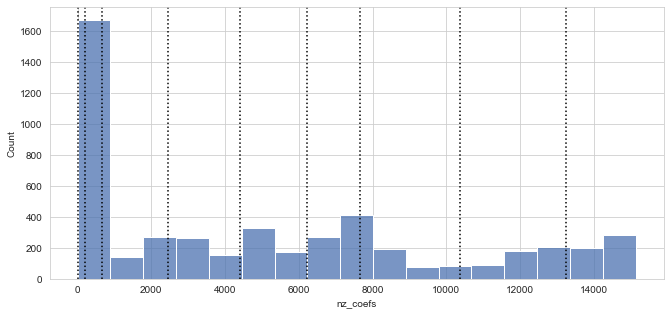

In [11]:
sns.set({'figure.figsize': (11, 5)})
sns.set_style('whitegrid')

sns.histplot(plot_df.nz_coefs)
for q in np.linspace(0.1, 0.9, 9):
    print(f'{q:.3f}', f'{plot_df.nz_coefs.quantile(q):3f}')
    plt.gca().axvline(x=plot_df.nz_coefs.quantile(q), color='black', linestyle=':')

In [12]:
plot_df['nz_quantile'] = pd.qcut(
    plot_df.nz_coefs,
    q=np.linspace(0, 1, 11),
    labels=[f'{q}' for q in range(1, 11)]
)

print(plot_df.nz_quantile.unique())
plot_df.head()

['1', '2', '3', '4', '5', '6', '8', '9', '10', '7']
Categories (10, object): ['1' < '2' < '3' < '4' ... '7' < '8' < '9' < '10']


,auroc,aupr,gene_x,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param,gene_y,nz_coefs,nz_quantile
0,0.5,0.128400,EGFR,BLCA,signal,42,train,0,liblinear,0.001,EGFR,0,1
1,0.5,0.081633,EGFR,BLCA,signal,42,test,0,liblinear,0.001,EGFR,0,1
2,0.5,0.132390,EGFR,BLCA,signal,42,cv,0,liblinear,0.001,EGFR,0,1
3,0.5,0.130180,EGFR,BLCA,signal,42,train,1,liblinear,0.001,EGFR,0,1
4,0.5,0.081633,EGFR,BLCA,signal,42,test,1,liblinear,0.001,EGFR,0,1


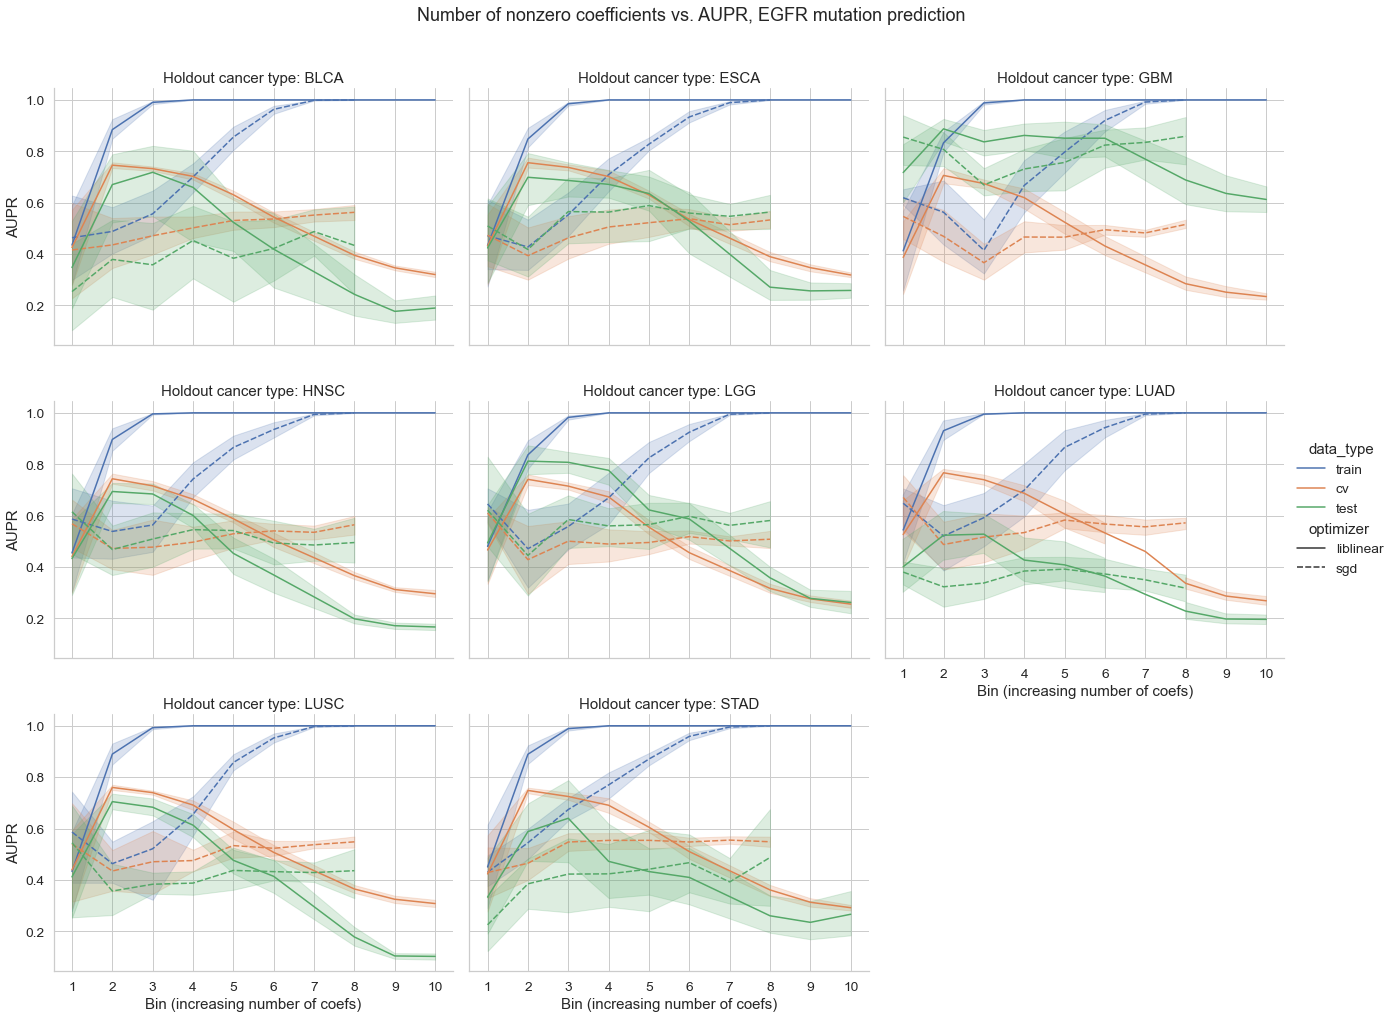

In [13]:
# compare optimizers for MSI prediction on the same plot
sns.set_style('whitegrid')

with sns.plotting_context('notebook', font_scale=1.25):
    g = sns.relplot(
        data=plot_df,
        x='nz_quantile', y=metric,
        hue='data_type', hue_order=['train', 'cv', 'test'],
        style='optimizer', style_order=['liblinear', 'sgd'],
        kind='line', col='holdout_cancer_type',
        col_wrap=3, height=4.5, aspect=1.35
    )
    g.set_titles('Holdout cancer type: {col_name}')
    g.set_xlabels('Bin (increasing number of coefs)')
    g.set_ylabels(f'{metric.upper()}')
    plt.suptitle(f'Number of nonzero coefficients vs. {metric.upper()}, {plot_gene} mutation prediction', y=1.05)